In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
from torch.optim import Adam
from tqdm import tqdm 

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [4]:
train_dir = 'D:/datasets/DL/flowers/train'
test_dir = "D:/datasets/DL/flowers/test"

In [5]:
train_dataset = datasets.ImageFolder(root=train_dir, transform=data_transforms)
test_dataset = datasets.ImageFolder(root=test_dir, transform=data_transforms)

In [6]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [7]:
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
num_classes = len(train_dataset.classes)
model.fc = nn.Linear(num_ftrs, num_classes)

C:\Users\Tanmay LImje\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Tanmay LImje\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
model = model.to(device)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.fc.parameters(), lr=0.001)

In [10]:
num_epochs = 10
for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    model.train()

    running_loss = 0.0
    running_corrects = 0

    with tqdm(train_loader, unit="batch") as tbar:
        tbar.set_description(f"Epoch {epoch+1}/{num_epochs}")

        for inputs, labels in tbar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            tbar.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
    print(f'Training Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

Epoch 0/9


Epoch 1/10: 100%|██████████| 102/102 [00:28<00:00,  3.61batch/s, loss=0.495]


Training Loss: 0.7408 Acc: 0.7455
Epoch 1/9


Epoch 2/10: 100%|██████████| 102/102 [00:27<00:00,  3.69batch/s, loss=0.245]


Training Loss: 0.3980 Acc: 0.8714
Epoch 2/9


Epoch 3/10: 100%|██████████| 102/102 [00:28<00:00,  3.62batch/s, loss=0.487]


Training Loss: 0.3183 Acc: 0.8948
Epoch 3/9


Epoch 4/10: 100%|██████████| 102/102 [00:29<00:00,  3.48batch/s, loss=0.622]


Training Loss: 0.3071 Acc: 0.8929
Epoch 4/9


Epoch 5/10: 100%|██████████| 102/102 [00:29<00:00,  3.48batch/s, loss=0.181]


Training Loss: 0.2693 Acc: 0.9117
Epoch 5/9


Epoch 6/10: 100%|██████████| 102/102 [00:29<00:00,  3.51batch/s, loss=0.182]


Training Loss: 0.2613 Acc: 0.9058
Epoch 6/9


Epoch 7/10: 100%|██████████| 102/102 [00:33<00:00,  3.08batch/s, loss=0.112]


Training Loss: 0.2532 Acc: 0.9114
Epoch 7/9


Epoch 8/10: 100%|██████████| 102/102 [00:28<00:00,  3.57batch/s, loss=0.218] 


Training Loss: 0.2536 Acc: 0.9098
Epoch 8/9


Epoch 9/10: 100%|██████████| 102/102 [00:27<00:00,  3.68batch/s, loss=0.127]


Training Loss: 0.2211 Acc: 0.9240
Epoch 9/9


Epoch 10/10: 100%|██████████| 102/102 [00:27<00:00,  3.70batch/s, loss=0.222]

Training Loss: 0.2348 Acc: 0.9194


In [11]:
model.eval()
running_corrects = 0

with torch.no_grad():
    with tqdm(val_loader, unit="batch", desc="Validation") as vbar:
        for inputs, labels in vbar:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

val_acc = running_corrects.double() / len(test_dataset)
print(f'Validation Accuracy: {val_acc:.4f}')

Validation: 100%|██████████| 17/17 [00:04<00:00,  3.64batch/s]

Validation Accuracy: 0.9000


The predicted class is: dandelion


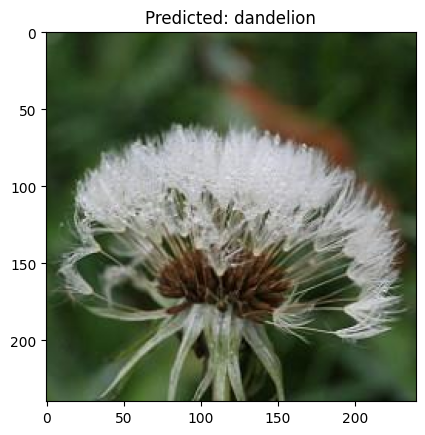

In [12]:
from PIL import Image
import matplotlib.pyplot as plt

def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    return image.unsqueeze(0)

def predict_image(image_path, model, class_names):
    model.eval()
    with torch.no_grad():
        image_tensor = preprocess_image(image_path).to(device)
        outputs = model(image_tensor)
        _, predicted_idx = torch.max(outputs, 1)
        predicted_class = class_names[predicted_idx.item()]
        return predicted_class

# Example usage:
image_path = "D:/datasets/DL/flowers/test/dandelion/dandelion_6.jpg"  # Replace with an actual image path
class_names = train_dataset.classes
predicted_class = predict_image(image_path, model, class_names)

print(f'The predicted class is: {predicted_class}')

# Display the image with predicted label
img = Image.open(image_path)
plt.imshow(img)
plt.title(f'Predicted: {predicted_class}')
plt.show()